<h1 align=center><font size = 6>What is the rent?</font></h1>
<h3 align=center><font size = 3>IBM Data Science Professional Certificate Course Final Project</font></h3>

## Table of Contents

<div style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Neighborhood Data</a>

2. <a href="#item2">Rental Data</a>

3. <a href="#item3">Clustering</a>
    
3. <a href="#item4">Foursquare Data</a>

4. <a href="#item5">Training and Prediction</a>

</font>
</div>

Let's import some packages we will use in this notebook

In [ ]:
import pandas as pd
import numpy as np

# Map
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping and json packages
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Machine Learning packages
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

<a id="item1"></a>
### 1. Neighborhood Data

Let's download the json file of the dataset. In order to utilize pandas library, we will convert it to DataFrame format.

In [ ]:
url="https://cocl.us/new_york_dataset"
data = requests.get(url).json()

In [ ]:
ng_data = data['features']

Now, we have all the name and the latitude/longitude information for each neighborhood along with other details about a neigborhood. We will not use all information in this dictionary.

In [ ]:
ng_data

In [ ]:
column_names=['Borough','Neighborhood','Latitude','Longitude']
df_neigh=pd.DataFrame(columns=column_names)
df_neigh

In [ ]:
# load dataframe with data
for data in ng_data:
    dt_p=data['properties']
    dt_g=data['geometry']
    df_neigh = df_neigh.append({'Borough': dt_p['borough'] ,
                                'Neighborhood': dt_p['name'] ,
                                'Latitude': dt_g['coordinates'][1],
                                'Longitude': dt_g['coordinates'][0]}, ignore_index=True)

Let's check how the data is looking. 

In [ ]:
df_neigh.head()

<a id="item2"></a>
### 2. Rental Data

To get the rental information I'm going to scrap _rentjungle.com_.

In [ ]:
rent_data=pd.read_csv("newyork_rent.csv")
rent_data.shape

Add rent information to the neighborhood dataset

In [ ]:
full_data=pd.merge(df_neigh, rent_data, on='Neighborhood', how='left')
merged_data=full_data.dropna()
merged_data.reset_index(inplace=True)
merged_data.head()

In [ ]:
type(merged_data['Average Rent'][0])

It looks like rent column is string. Let's convert it to integer. But before, we should remove the comma and the dollar sign.

In [ ]:
merged_data['Average Rent']=merged_data['Average Rent'].str.replace(',', '')
merged_data['Average Rent']=merged_data['Average Rent'].str.replace('$', '')

merged_data['Average Rent'][0]

In [ ]:
merged_data['Average Rent']=list(map(int,merged_data['Average Rent']))
type(merged_data['Average Rent'][0])

In [ ]:
merged_data['Average Rent'][0]

Let's look at the size of the final data. 

In [ ]:
merged_data.shape

It only has 34 rows. It shows that some rental information did not match the names of neighborhood names in neigh_data. I'm going to check the differences (it may result from grammar mistakes, whitespaces etc.) and try to fix them.

In [ ]:
df = rent_data.merge(df_neigh, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
df.reset_index(inplace=True)
df # These are the non-matched rows

After finalizing the data let's look how our rental data looks like on the map. We should mostly cover Manhattan.

In [ ]:
# Manhattan Coordinations
latitude=40.758896
longitude=-73.985130
rent_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, rent, neigh in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Average Rent'],merged_data['Neighborhood']):
    label = '{}, {}'.format(neigh,rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        fill=True,
        weight=0, # border line weight
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(rent_map)  
    
rent_map

<a id="item3"></a>
### 3. Clustering
I'm going to cluster neighborhoods with respect to their rents, so we can see which part of the manhattan is much expensive.

In [ ]:
# set number of clusters
kclusters = 3

merged_data_clustering = merged_data.drop(['index','Borough','Neighborhood','Latitude','Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merged_data_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

In [ ]:
merged_data.insert(0, 'Cluster Labels', kmeans.labels_)
merged_data.head()

Let's look at how the clusters are looking.

In [ ]:
# Manhattan Coordinations
latitude=40.758896
longitude=-73.985130
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Average Rent'], merged_data['Cluster Labels']):
    label = folium.Popup('Rent '+ str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Green markes shows the 'cheapest' neighborhood whereas red markes indicates the most expensive ones.

<a id="item4"></a>
### 4. Foursquare Data

Now, it's time to add our venue information to the dataset. I will create column for each venue category and put the number of venues as data. That way we will the examine the surrondings of these points.

In [ ]:
CLIENT_ID = '5DLM1N4NTPZA2ZLFQABIEXJNUTKJRW3BWRGIM22VXPBAMVIF' # your Foursquare ID
CLIENT_SECRET = 'H3SIPWCTTB0ARIIFODBPVZKBYT14EOYDF0ZLQFMKM1KS1SF1' # your Foursquare Secret
VERSION = '20180101' # Foursquare API version

In [ ]:
merged_data.head()

In [ ]:
neighborhood_longitude=merged_data['Longitude'][0]
neighborhood_latitude=merged_data['Latitude'][0]
LIMIT = 100 
radius = 500 

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

merged_data['Neighborhood'][0]

In [ ]:
results = requests.get(url).json()
results

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']   
nearby_venues = pd.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues['categories'].values

Above lines shows the first neighborhood's venue. Hence we should generalize it. Let's write a function

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
manhattan_venues = getNearbyVenues(names=merged_data['Neighborhood'],
                                   latitudes=merged_data['Latitude'],
                                   longitudes=merged_data['Longitude']
                                  )

In [ ]:
manhattan_venues.groupby('Neighborhood').count()

In [ ]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

In [ ]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

In [ ]:
num_top_venues = 5
for hood in manhattan_grouped['Neighborhood']:
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [ ]:
#nearby_venues.loc[nearby_venues['categories']=='Sandwich Place']
full_data=pd.merge(manhattan_grouped, merged_data, on='Neighborhood', how='left')
full_data=full_data.dropna()
full_data.reset_index(inplace=True)
full_data.head()

In [ ]:
full_data.shape

There are 321 features in data which is way too much for this small data. It will definitely cause overfitting. Hence we should find appropriate columns. In other words, we should select features that are correlated with our target value, the rent.

In [ ]:
#Using Pearson Correlation
cor = full_data.corr()
cor_target = abs(cor["Average Rent"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features=pd.DataFrame(relevant_features)
relevant_features.reset_index(inplace=True)
relevant_features
cor2=full_data[relevant_features['index']].corr()
#cor2
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
final_data=full_data[relevant_features['index']]
final_data

<a id="item5"></a>
### 5. Regression - Can we predict rent price for an apartment?

The problem here is to predict a continues number, i.e., the rent. Hence I'm going to use linear regression models. Since I have multiple features (i.e., columns), I will start with multiple regression.

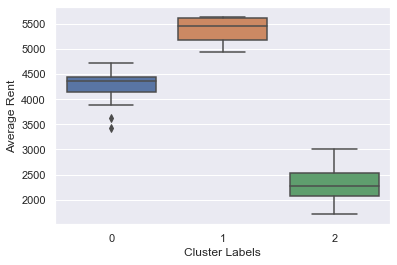

In [168]:
sns.boxplot(x='Cluster Labels',y='Average Rent',data=full_data)

#### Train

Scikit-learn uses plain Ordinary Least Squares method to solve this problem. You can use different optimization approaches as well, but since I don't have a large dataset I'm going to stick with OLS.
And again because of small dataset, I used Kfold for training.

In [ ]:
relevant_features_X=relevant_features.drop(relevant_features.index[9])
relevant_features_X['index']

In [ ]:
X=final_data[relevant_features_X['index']]
y=final_data[['Average Rent']]

# Regression Model
regr = linear_model.LinearRegression()
scores=[]

kf=KFold(n_splits=3, random_state=None, shuffle=False)
i=0
for train_index, test_index in kf.split(X):
    i=i+1
    print("Iteration ",i)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    regr.fit (X_train, y_train)
    print ('Coefficients: ', regr.coef_)
    y_hat=regr.predict(X_test)
    scores.append(r2_score(y_test, y_hat))

scores=pd.DataFrame(scores)
scores.columns=['Scores']
scores

I've used R-squared for evaluation. R squared is not an error per se but is a popular metric for the accuracy of your model. It represents how close the data values are to the fitted regression line. The higher the R-squared, the better the model fits your data.    

Below plot depicts the accuracy for each iteration.

In [ ]:
### Visualize accuracy for each iteration
scores = pd.DataFrame(scores,columns=['Scores'])
 
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3'],y="Scores",data=scores)
plt.show()
sns.set()

In [ ]:
train_index=[0,1,2,3,4 ,5 , 6 , 7 , 8 , 9 ,10 ,11 ,23 ,24 ,25, 26 ,27, 28, 29 ,30 ,31, 32, 33]
test_index=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
# Regression Model
#X=final_data[relevant_features_X['index']]
y=final_data[['Average Rent']]
regr = linear_model.LinearRegression()
regr.fit (X_train, y_train)
y_hat=regr.predict(X)

#### Discussion and Conclusion

This study can be used to give someone an idea about the rent of a house they are interested in. Why this is different from other regular rental website is that we are considering the srroundings of the house. So it will output a fair price for it.